In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import time

In [2]:
# reading a map
def get_map(path, nside):
    map = hp.read_map(path)
    map = hp.ud_grade(map,nside_out=nside)
    map[np.isnan(map)==True]=0.
    map[np.isinf(map)==True]=0.
    return map

#reading a weight
def get_weight(path,nside):
    map = hp.read_map(path)
    weight = np.zeros(hp.nside2npix(hp.get_nside(map)))
    weight[map>0.] = 1.
    weight = hp.ud_grade(weight,nside_out=nside)
    weight[weight>0.] = 1.
    return weight

# mean subtraction
def get_map_zero_mean(map, weight):
    norm = sum(weight*map)/sum(weight)
    map_zero_mean = weight*map/norm - weight
    return map_zero_mean

#corr. calculator
def get_twopt_corr(theta_bins, map1, map2, weight, nside):
    pixel_indices = np.where(weight>0.)[0]
    
    delta1 = get_map_zero_mean(map1,weight)
    delta2 = get_map_zero_mean(map2,weight)
    
    n_points = len(pixel_indices)
    pixel_counts = np.zeros(nbins)
    correlation_counts = np.zeros(nbins)
    for i in range(n_points):
        pixel_center = pixel_indices[i]
        neighbors = hp.query_disc(nside, hp.pix2vec(nside, pixel_center), np.pi/90.)  # Query the disc around the current pixel
        for neighbor in neighbors:
            sep = hp.rotator.angdist(hp.pix2ang(nside, pixel_center), hp.pix2ang(nside, neighbor))  # Calculate angular separation
            bin_index = np.searchsorted(theta_bins, sep)
            pixel_counts[bin_index - 1] += 1
            
            if weight[neighbor]==1. :
                correlation_counts[bin_index - 1] += delta1[pixel_center]*delta2[neighbor]  # Increment the count in the corresponding bin

    # Normalize the correlation function
    print(pixel_counts)
    print(correlation_counts)
    # Normalize the correlation function
    correlation_function = correlation_counts/pixel_counts
    
    return correlation_function

In [3]:
#Healpixconfig.
nside = 256
npix = hp.nside2npix(nside)
theta_pix = np.sqrt(hp.nside2pixarea(nside,degrees=True))
print(theta_pix)

# Angular binning for correlation function
nbins = 20
theta_bins = np.linspace(theta_pix*np.pi/180, np.pi/90., nbins + 1)
print(theta_bins)

0.2290324274544937
[0.00399737 0.00554283 0.00708829 0.00863375 0.01017921 0.01172467
 0.01327013 0.0148156  0.01636106 0.01790652 0.01945198 0.02099744
 0.0225429  0.02408836 0.02563382 0.02717928 0.02872474 0.0302702
 0.03181566 0.03336112 0.03490659]


In [4]:
# get maps
root = '../../../fits/HSC_ACT/goldrush'
maps = {'LBGs': get_map(root+'/cmap_SigmaClippedAround_SNcutted_gri_all-areas_i_fluxcut25p5_nside%d.fits'%nside,nside),
             #'g_stars': get_map(root+'/cmap_SigmaClippedAround_SNcutted_gri_all-areas_i_fluxcut25p5_stars_g_extendedness0_nside%d.fits'%nside,nside),
             'r_stars': get_map(root+'/cmap_SigmaClippedAround_SNcutted_gri_all-areas_i_fluxcut25p5_stars_r_extendedness0_nside%d.fits'%nside,nside),
             'i_stars': get_map(root+'/cmap_SigmaClippedAround_SNcutted_gri_all-areas_i_fluxcut25p5_stars_i_extendedness0_nside%d.fits'%nside,nside),
             'g_fluxsigma2': get_map(root+'/cmap_g_fluxsigma2_all-areas_nside%d.fits'%nside,nside),
             'r_fluxsigma2': get_map(root+'/cmap_r_fluxsigma2_all-areas_nside%d.fits'%nside,nside),
             'i_fluxsigma2': get_map(root+'/cmap_i_fluxsigma2_all-areas_nside%d.fits'%nside,nside),
             'i_sdss_seeing': get_map(root+'/cmap_i_sdss_FWHM_nside%d_all-areas.fits'%nside,nside)
             }
#get weight
weight = get_weight(root+'/cmap_SigmaClippedAround_SNcutted_gri_all-areas_i_fluxcut25p5_nside1024.fits',nside)
map_names = list(maps.keys())
print(map_names)

['LBGs', 'r_stars', 'i_stars', 'g_fluxsigma2', 'r_fluxsigma2', 'i_fluxsigma2', 'i_sdss_seeing']


In [5]:
print(len(weight))

786432


In [6]:
print(min(maps['g_fluxsigma2']))
print(min(maps['r_fluxsigma2']))
print(min(maps['i_fluxsigma2']))
print(max(maps['g_fluxsigma2']))
print(max(maps['r_fluxsigma2']))
print(max(maps['i_fluxsigma2']))

0.0
0.0
0.0
9.349919507037323e-62
2.760465434416811e-61
2.954548486577479e-60


<class 'str'>
LBGs


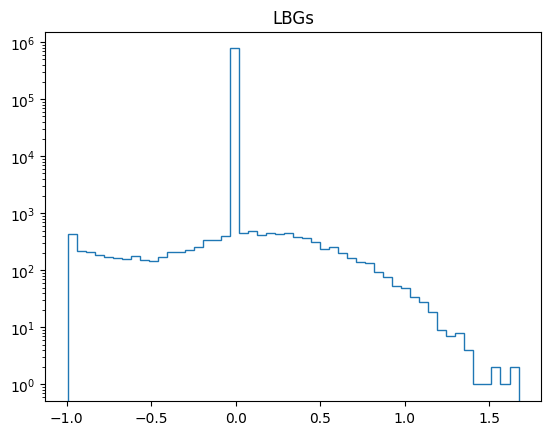

r_stars


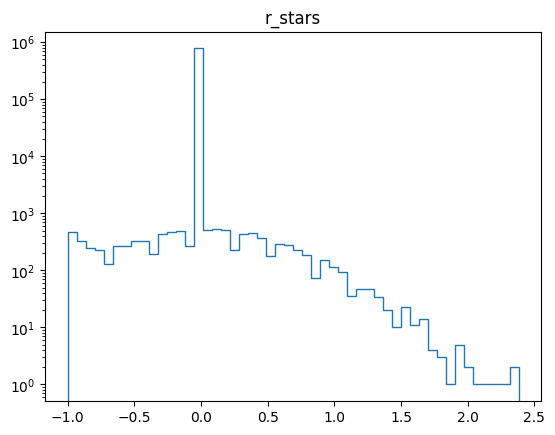

i_stars


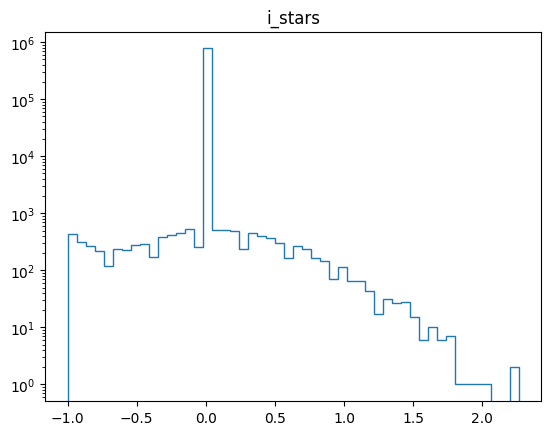

g_fluxsigma2


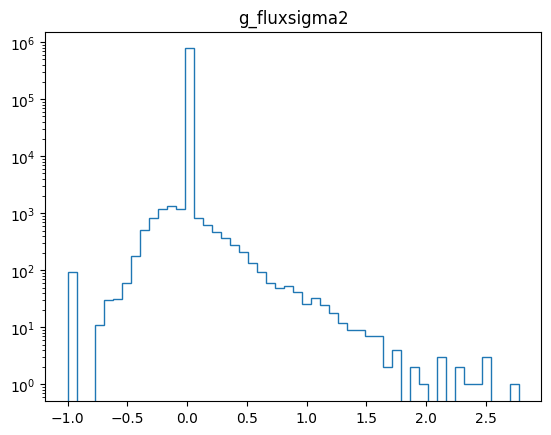

r_fluxsigma2


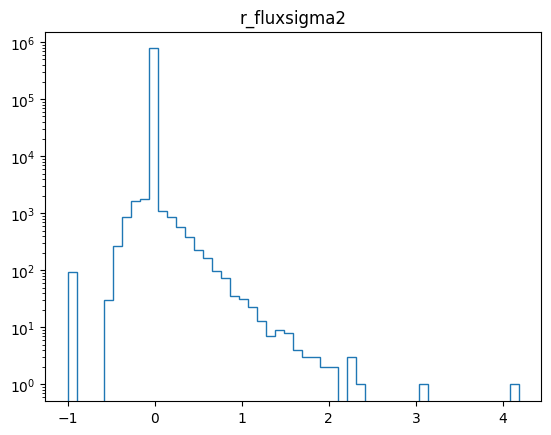

i_fluxsigma2


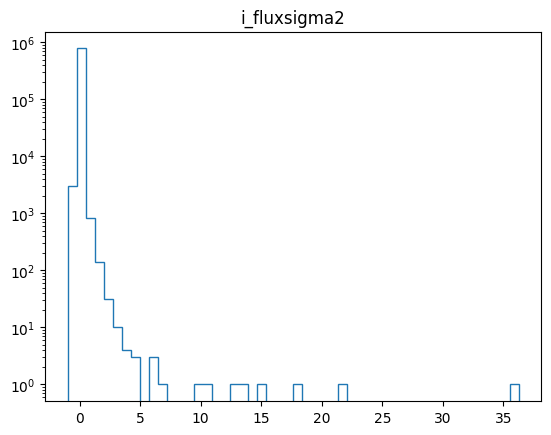

i_sdss_seeing


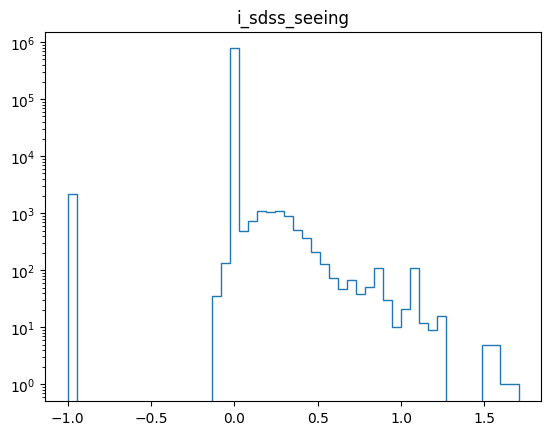

In [7]:
print(type(map_names[1]))
#check histogram
deltas = {}
for map_name in map_names:
    print(map_name)
    deltas[map_name] = get_map_zero_mean(maps[map_name],weight)
    plt.title('%s'%map_name)
    plt.hist(deltas[map_name], bins=50,histtype='step')
    plt.yscale('log')
    plt.show()

In [8]:
# generating corr. keys

def twopt_iter():
    i = 0
    for i1, nm1 in enumerate(map_names):
        for i2, nm2 in enumerate(map_names):
            # Skip repeated 
            if i2 < i1:
                continue
            twopt_name = f'{nm1}_vs_{nm2}'
            yield i, i1, i2, nm1, nm2, twopt_name
            i += 1

LBGs_vs_LBGs
computing LBGs_vs_LBGs corr. func. 
[ 57779.  19767.  77109.  39999.  26384.  94898.  81852. 131250.  83614.
  99673. 135956. 121290. 118436. 212993. 103451. 196538. 158750. 163108.
 232052. 209970.]
[7949.7796062  2721.86769276 6654.61253812 4765.3182327  1270.87742198
 6963.09988825 4934.26885587 7849.21592229 3370.27135537 6198.6706105
 3781.93095768 5957.19072971 3275.66765352 7542.88609555 1594.80079842
 6775.43404241  815.00417094 5358.38257752 1920.92463998 7809.80718404]
computation finshed in 1.749096e+02 sec. 
LBGs_vs_r_stars
computing LBGs_vs_r_stars corr. func. 
[ 57779.  19767.  77109.  39999.  26384.  94898.  81852. 131250.  83614.
  99673. 135956. 121290. 118436. 212993. 103451. 196538. 158750. 163108.
 232052. 209970.]
[7405.98732456 2538.25594483 6036.69985027 4440.01169497 1074.88336834
 6366.11143541 4457.00129629 7204.23160034 3015.38253888 5743.9874336
 3507.3908208  5492.75714904 3144.29027089 7086.85953952 1552.5375726
 6438.51564651  992.70139961 50

[ 57779.  19767.  77109.  39999.  26384.  94898.  81852. 131250.  83614.
  99673. 135956. 121290. 118436. 212993. 103451. 196538. 158750. 163108.
 232052. 209970.]
[-1662.2140123   -650.81083106 -1126.95086344 -1030.1790043
  -133.06813792 -1069.9599872   -569.11023452  -998.54565871
  -126.83271744  -911.20016496   330.49020339  -594.32537289
   117.8869941   -171.82474602   376.46876684  -270.60814915
  1066.91444546  -306.204564    1344.83718858  -456.69349706]
computation finshed in 1.682296e+02 sec. 
i_stars_vs_i_fluxsigma2
computing i_stars_vs_i_fluxsigma2 corr. func. 
[ 57779.  19767.  77109.  39999.  26384.  94898.  81852. 131250.  83614.
  99673. 135956. 121290. 118436. 212993. 103451. 196538. 158750. 163108.
 232052. 209970.]
[-4236.37649892 -1396.99207716 -4404.42323956 -2381.08635417
 -1156.80824064 -4650.8773101  -3522.32858389 -5403.89659072
 -2840.18469629 -4011.75311764 -3784.69381199 -4076.0909567
 -3169.52477351 -5768.94969861 -2176.75403978 -5052.22170068
 -2526.9276

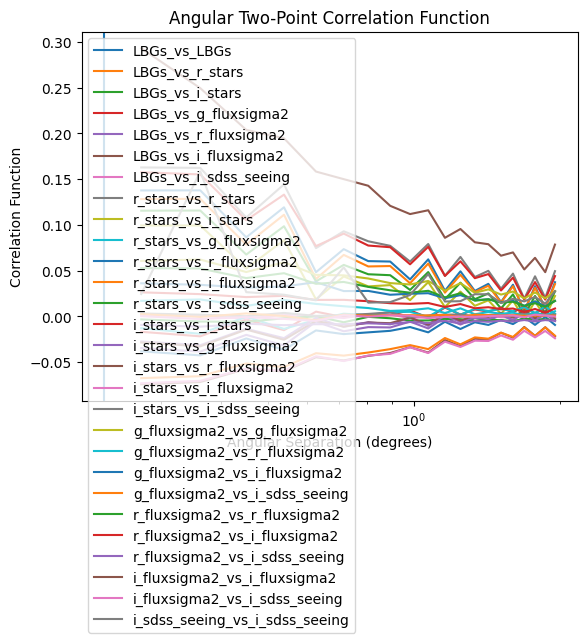

In [9]:
w ={}
for i, _, _, nm1, nm2, twopt_name in twopt_iter():
    print(twopt_name)
    m1 = maps[nm1]
    m2 = maps[nm2]
    start = time.perf_counter()
    print('computing %s corr. func. '%twopt_name)
    w[twopt_name] = get_twopt_corr(theta_bins, m1,m2, weight, nside)
    end = time.perf_counter()
    print('computation finshed in %e sec. '%(end-start))
    theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
    plt.plot(np.degrees(theta_mid), w[twopt_name], label = twopt_name)

# Plot the correlation function
plt.axvline(theta_pix)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Angular Separation (degrees)')
plt.ylabel('Correlation Function')
plt.title('Angular Two-Point Correlation Function')
plt.legend()
plt.show()

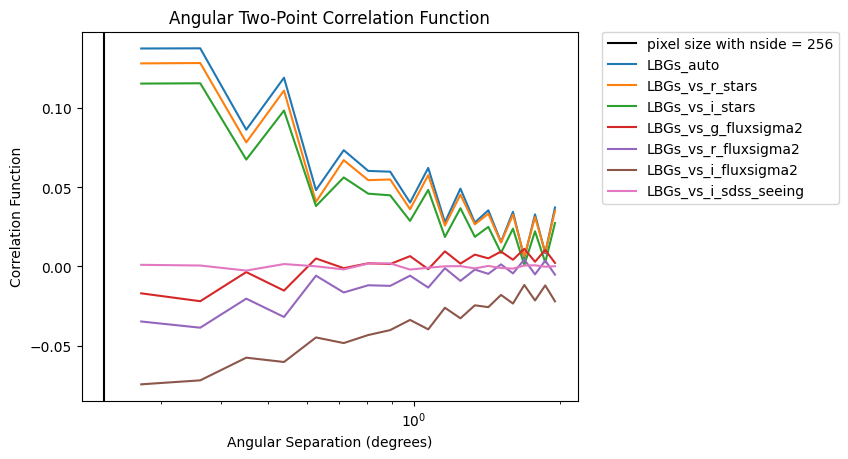

In [11]:
# cross corr. with LBGs
plt.axvline(theta_pix, color='black', label='pixel size with nside = %d'%nside)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Angular Separation (degrees)')
plt.ylabel('Correlation Function')
theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
plt.plot(np.degrees(theta_mid), w['LBGs_vs_LBGs'], label = 'LBGs_auto')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_r_stars'], label = 'LBGs_vs_r_stars')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_i_stars'], label = 'LBGs_vs_i_stars')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_g_fluxsigma2'], label = 'LBGs_vs_g_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_r_fluxsigma2'], label = 'LBGs_vs_r_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_i_fluxsigma2'], label = 'LBGs_vs_i_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_i_sdss_seeing'], label = 'LBGs_vs_i_sdss_seeing')
plt.title('Angular Two-Point Correlation Function')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()

In [52]:
i1=0
i2=0
n = len(map_names)
m = len(theta_mid)
w_c = np.zeros(m)
corr_mat = np.zeros((m,n,n),dtype=float)
#sanity check for initialisation

for i in range(m):
    w_sys = np.zeros((n,n), dtype=float)
    for i1, nm1 in enumerate(map_names):
        for i2, nm2 in enumerate(map_names):
            # Skip repeated 
            if i2 < i1:
                continue
            twopt_name = f'{nm1}_vs_{nm2}'
            #print(w[twopt_name])
            w_sys[i1,i2] = w[twopt_name][i]
            w_sys[i2,i1] = w_sys[i1,i2] #symmmetrisation
            
    #computing correlations
    for i1, _ in enumerate(map_names):
        for i2, _ in enumerate(map_names):
            # Skip repeated 
            if i2 < i1:
                continue
            corr_mat[i, i1, i2] = w_sys[i1,i2]/np.sqrt(w_sys[i1,i1])/np.sqrt(w_sys[i2,i2])
            corr_mat[i, i2, i1] = corr_mat[i, i1, i2] #symmmetrisation
    
    #sanity check
    #print(w['LBGs_vs_LBGs'][i], w_sys[0,0])
    A = np.linalg.inv(w_sys[1:,1:])
    y = w_sys[0, 1:]
    w_c[i] = w_sys[0,0] - np.dot(y.T, np.dot(A,y))

print('corrected 2pt is...')
print(w_c)
print('corr.mat. is...')
print(corr_mat)

corrected 2pt is...
[0.02176323 0.02096456 0.0178221  0.01925479 0.01121259 0.01542381
 0.01366171 0.0127208  0.01014376 0.01179372 0.00584093 0.01003707
 0.00588762 0.00762929 0.0002384  0.00686855 0.012718   0.00640334
 0.01382386 0.00769974]
corr.mat. is...
[[[ 1.00000000e+00  8.56556235e-01  7.84108675e-01 -1.86571958e-01
   -4.09230058e-01 -3.70859881e-01  1.69782872e-02]
  [ 8.56556235e-01  1.00000000e+00  6.20067018e-01 -1.31927853e-01
   -4.15351367e-01 -3.10043828e-01 -5.54216644e-02]
  [ 7.84108675e-01  6.20067018e-01  1.00000000e+00 -2.82539616e-01
   -3.16158361e-01 -3.41272975e-01  4.78465276e-02]
  [-1.86571958e-01 -1.31927853e-01 -2.82539616e-01  1.00000000e+00
    2.97866114e-01  2.70443346e-01  5.85313051e-02]
  [-4.09230058e-01 -4.15351367e-01 -3.16158361e-01  2.97866114e-01
    1.00000000e+00  2.10326757e-01 -2.64843213e-01]
  [-3.70859881e-01 -3.10043828e-01 -3.41272975e-01  2.70443346e-01
    2.10326757e-01  1.00000000e+00  1.17646375e-04]
  [ 1.69782872e-02 -5.542

In [22]:
''''
def w_corrected():
    w00 = w['LBGs_vs_LBGs'] 
    w01 = w['LBGs_vs_r_stars']
    w02 = w['LBGs_vs_i_stars']
    w03 = w['LBGs_vs_g_fluxsigma2']
    w04 = w['LBGs_vs_r_fluxsigma2']
    w05 = w['LBGs_vs_i_fluxsigma2']
    w06 = w['LBGs_vs_i_sdss_seeing']
    
    w11 = w['r_stars_vs_r_stars']
    w22 = w['i_stars_vs_i_stars']
    w33 = w['g_fluxsigma2_vs_g_fluxsigma2']
    w44 = w['r_fluxsigma2_vs_r_fluxsigma2']
    w55 = w['i_fluxsigma2_vs_i_fluxsigma2']
    w66 = w['i_sdss_seeing_vs_i_sdss_seeing']
    
    wc = w00 - w01**2./w11 -  w02**2./w22 - w03**2./w33 - w04**2./w44 - w05**2./w55 - w06**2./w66
    return wc
''''

(20,)


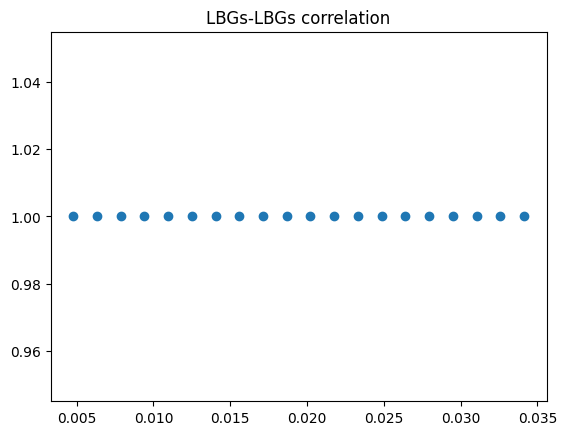

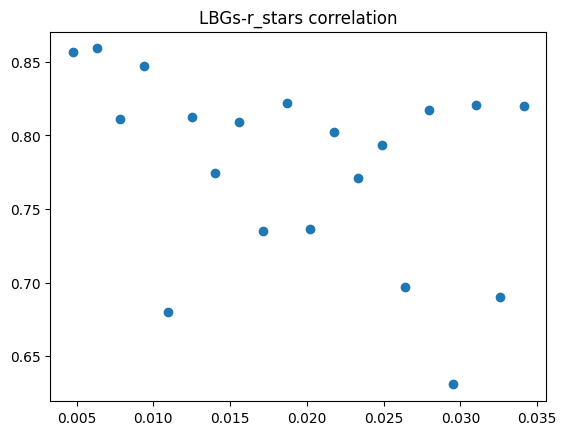

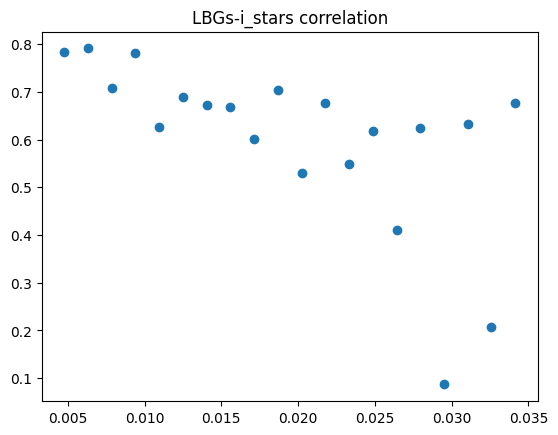

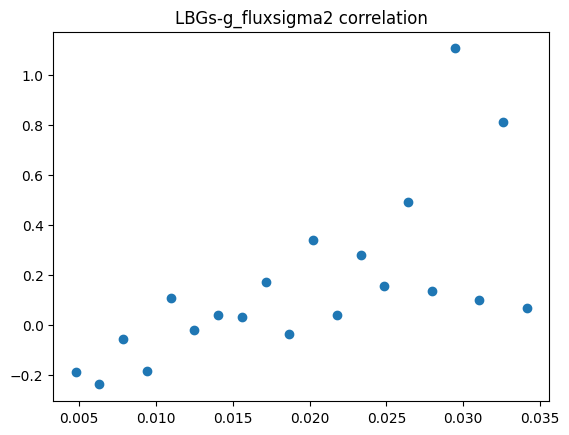

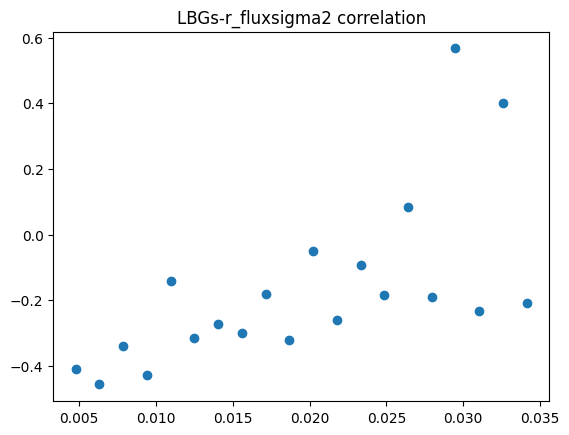

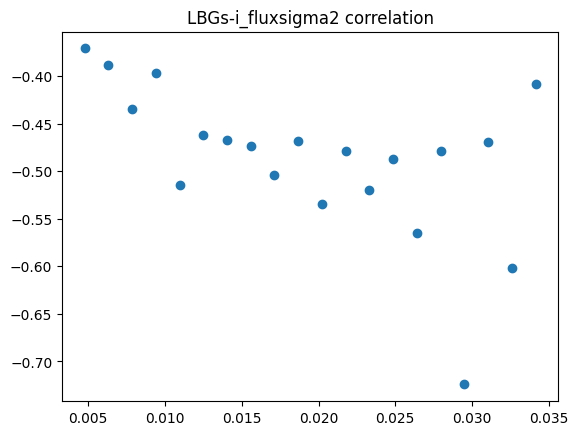

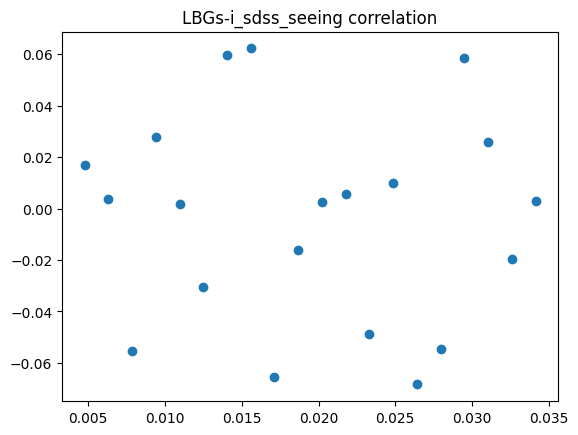

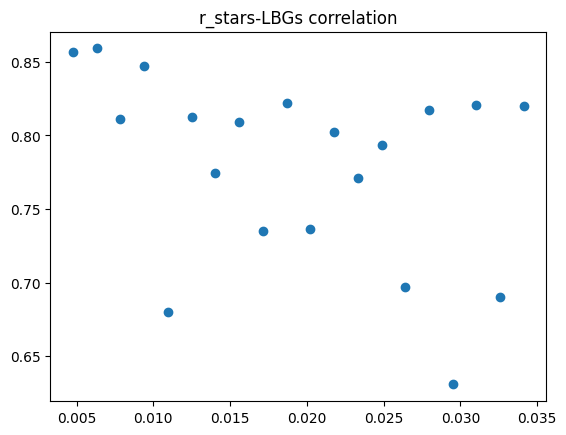

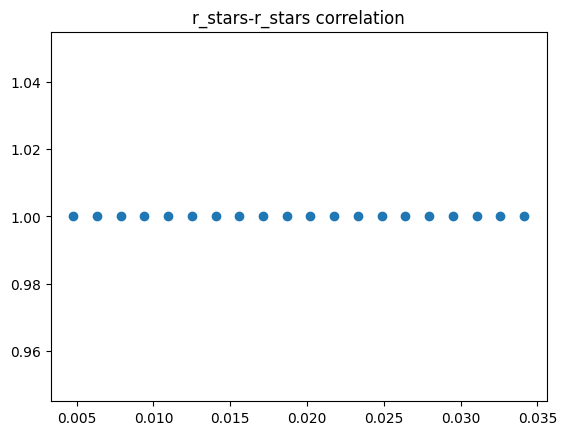

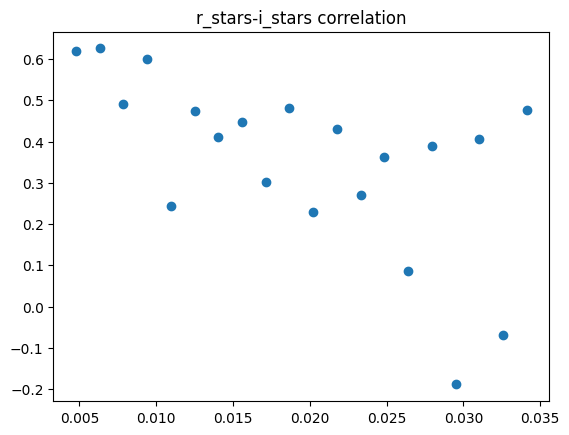

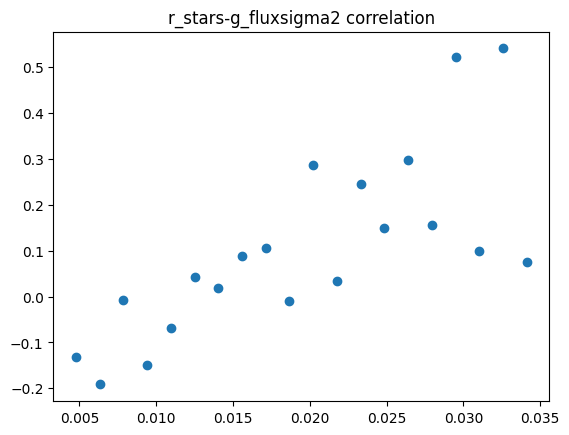

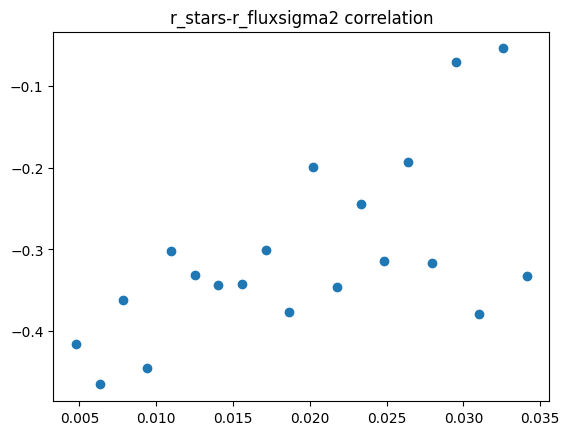

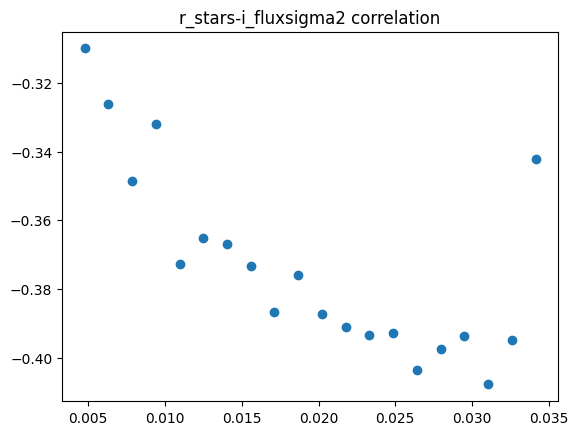

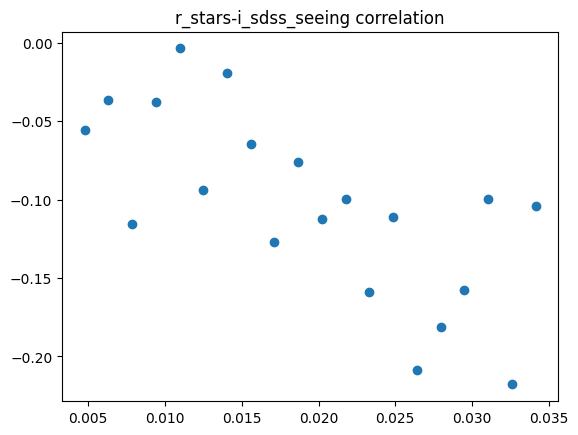

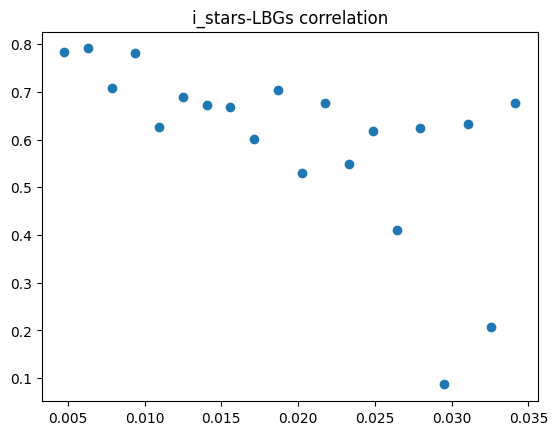

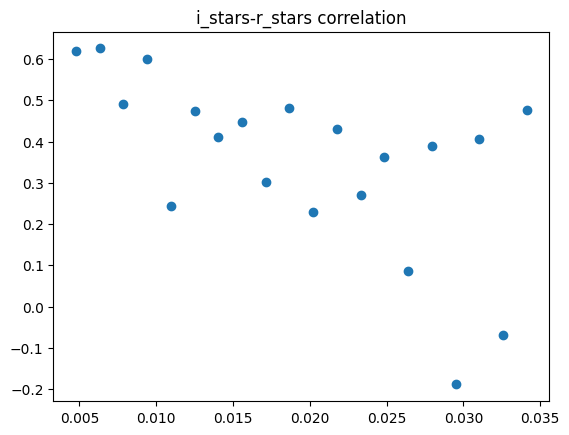

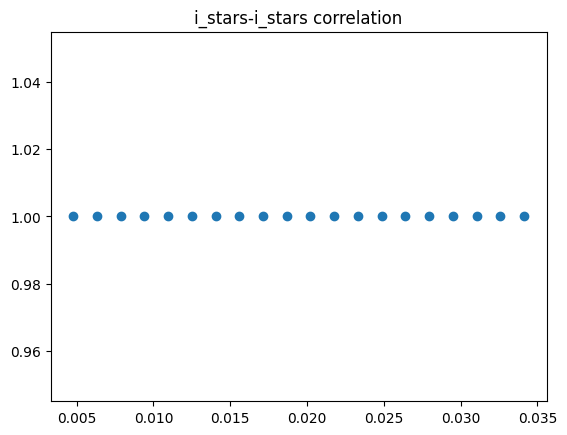

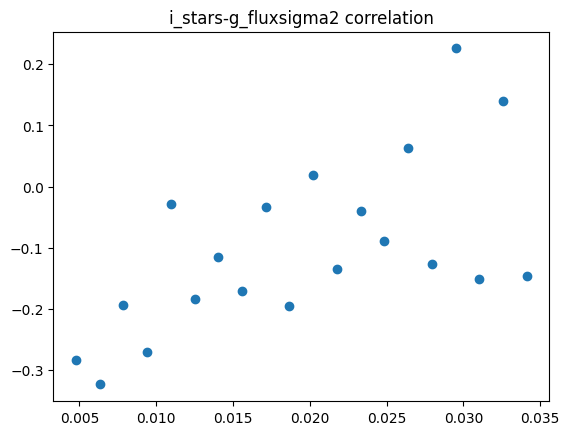

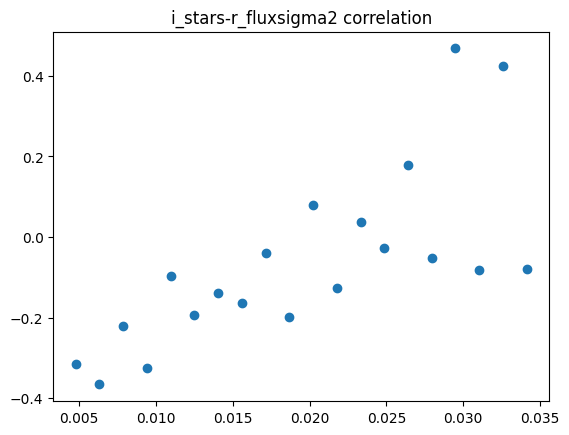

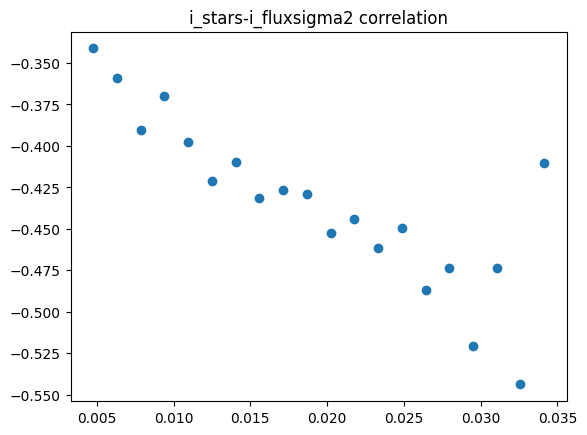

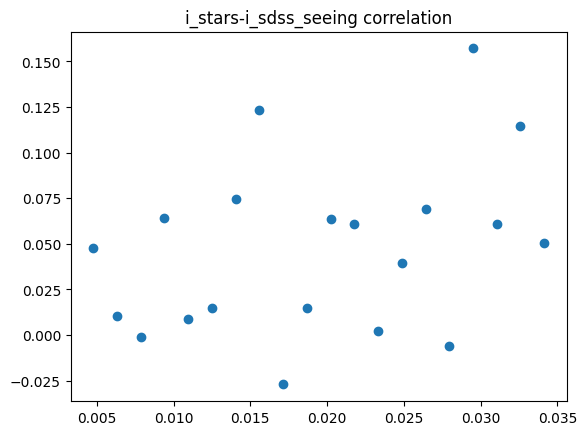

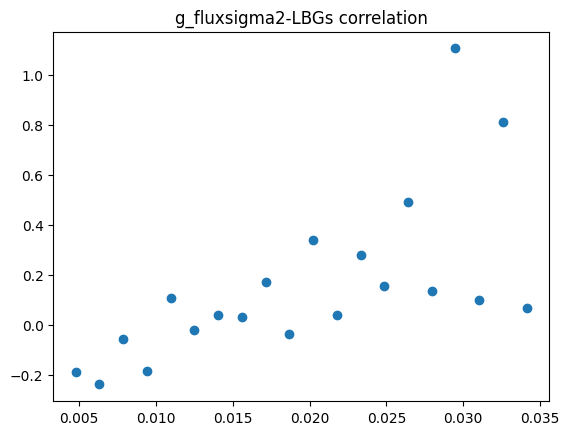

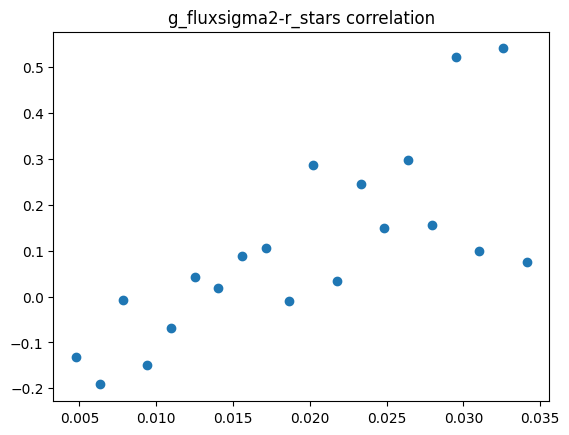

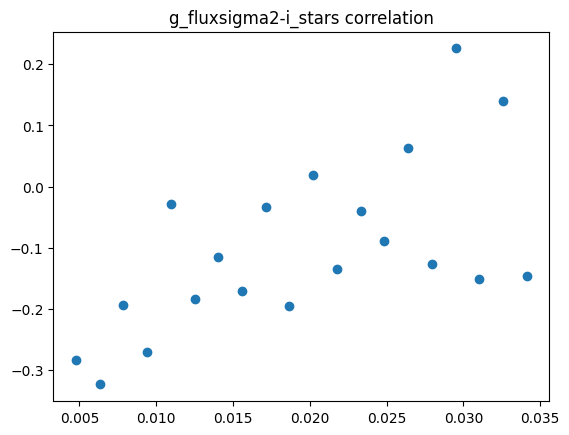

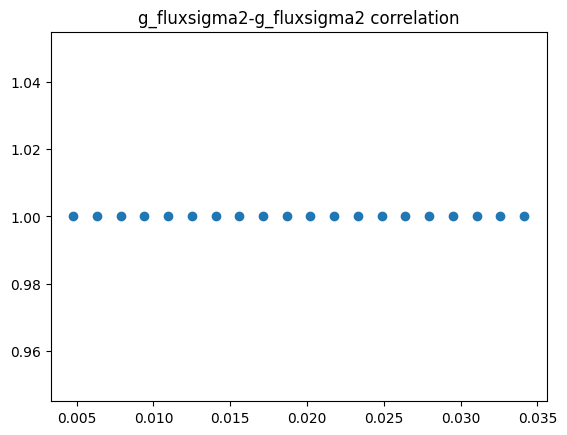

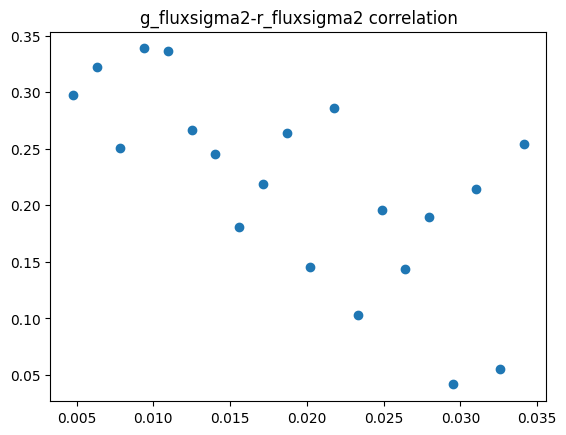

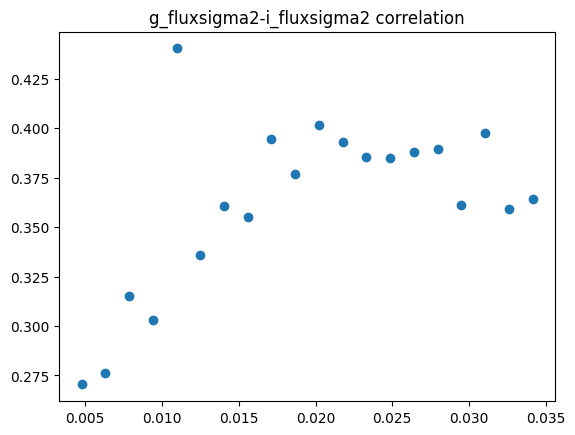

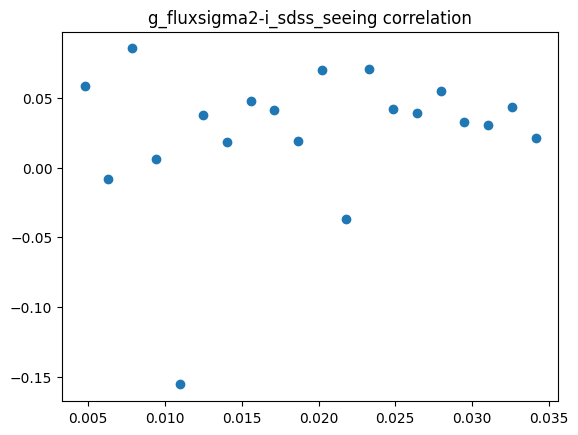

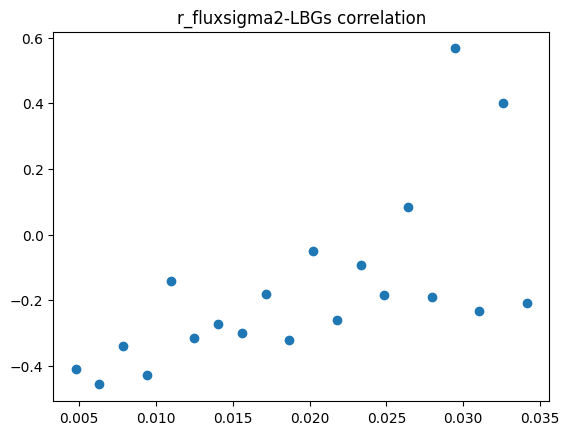

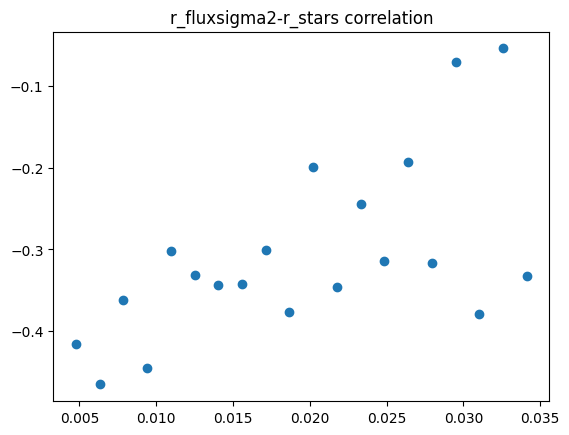

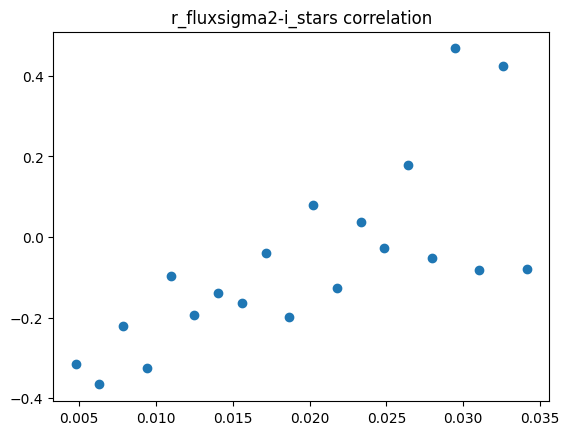

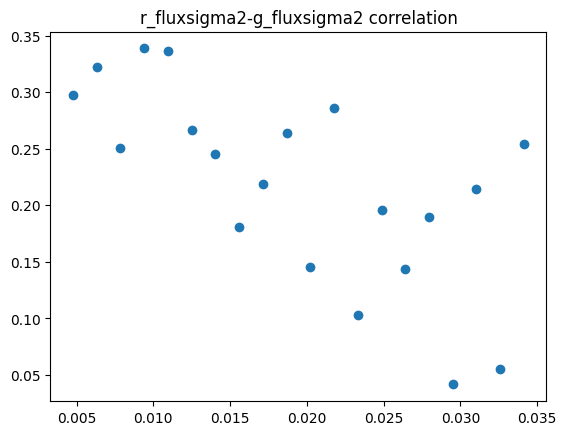

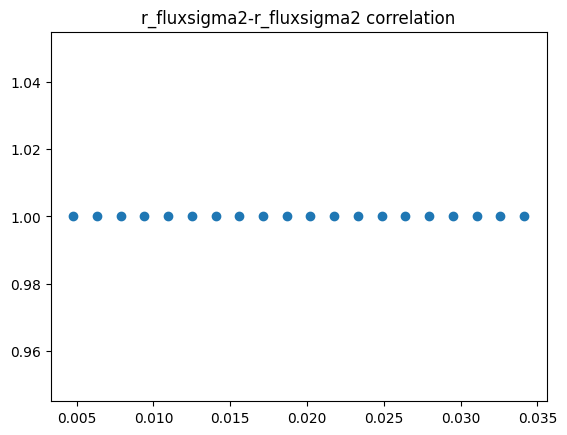

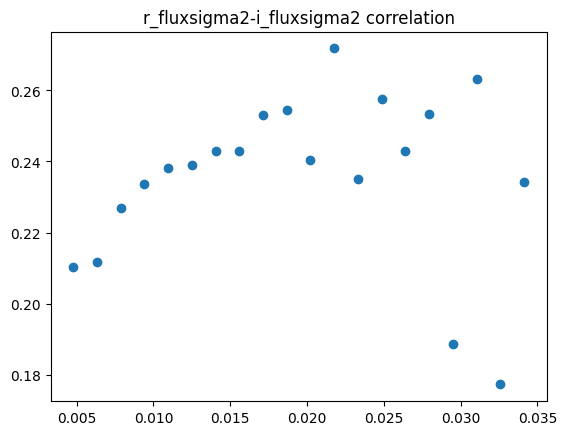

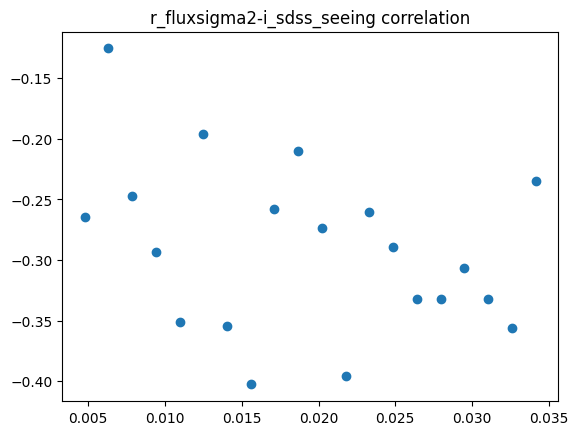

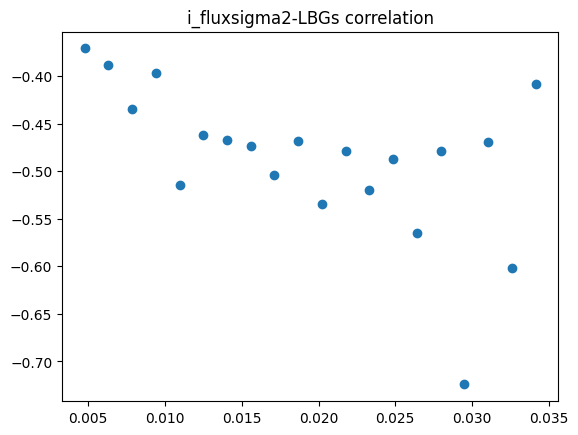

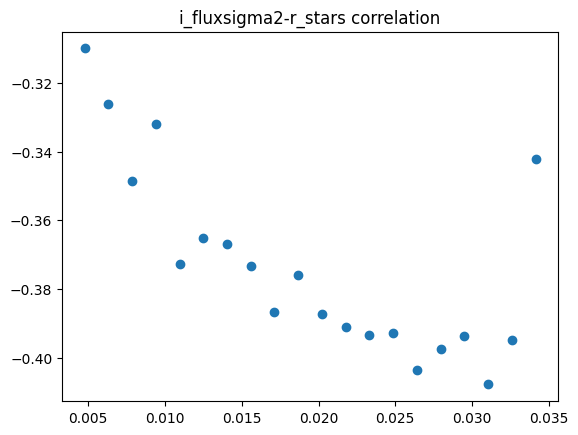

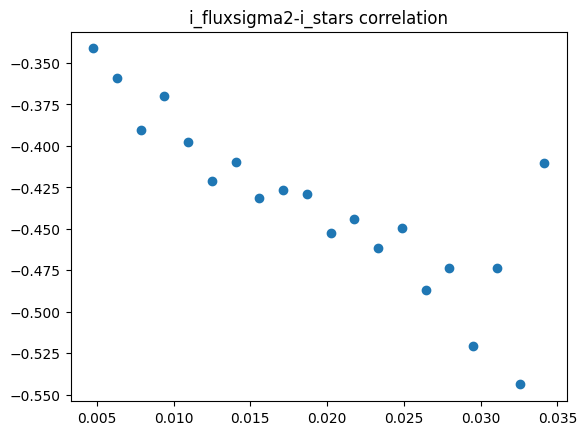

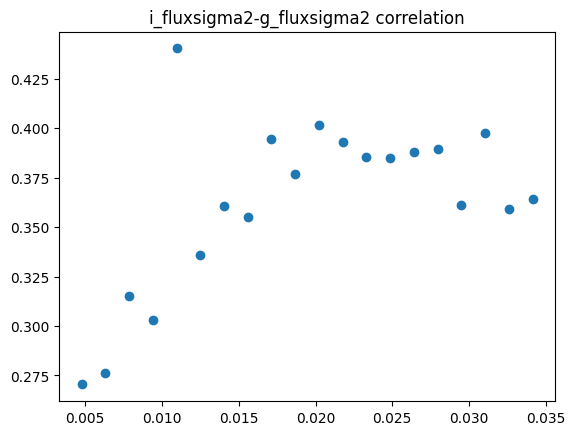

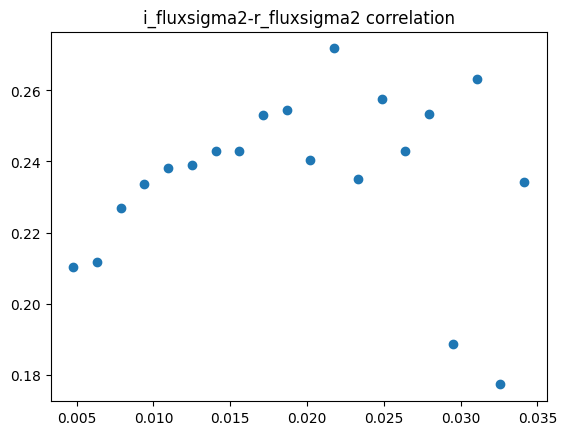

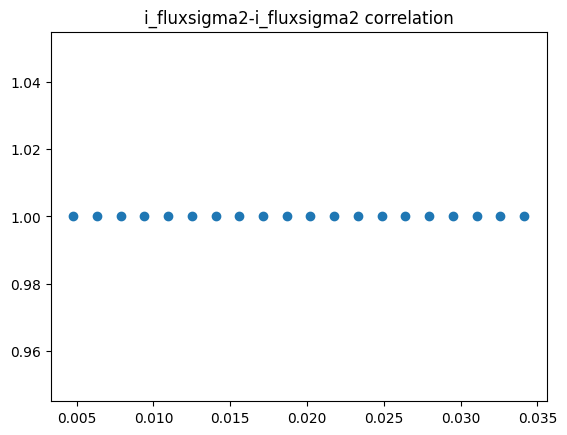

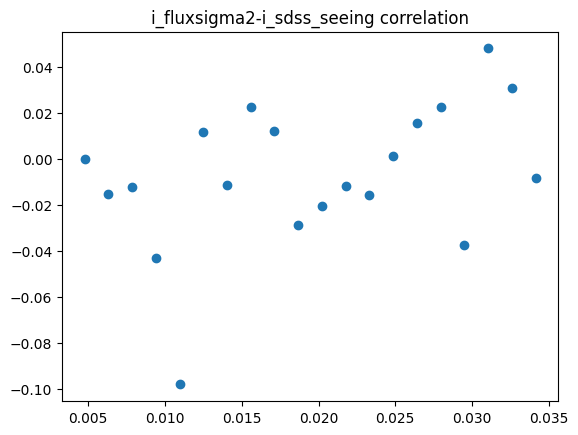

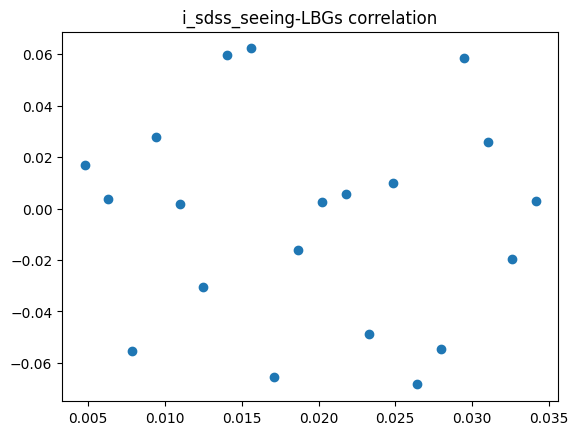

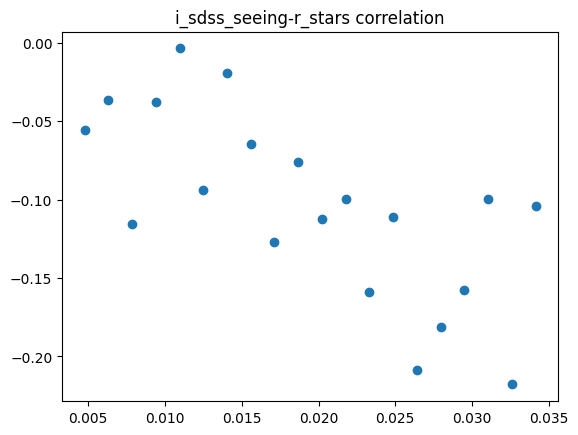

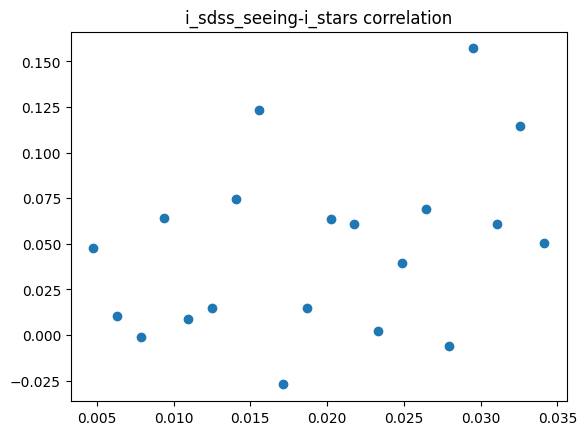

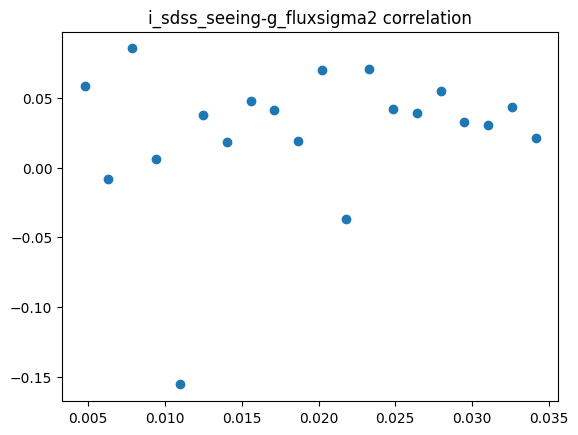

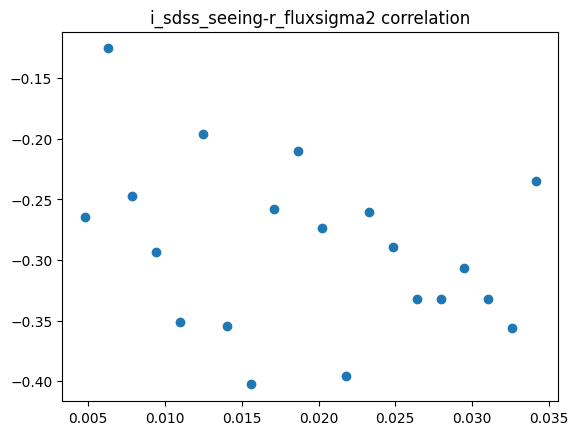

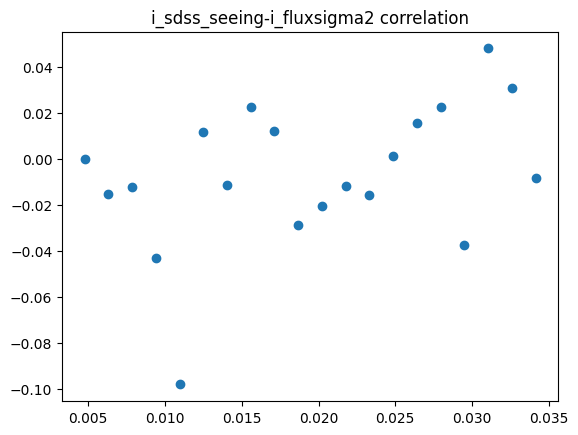

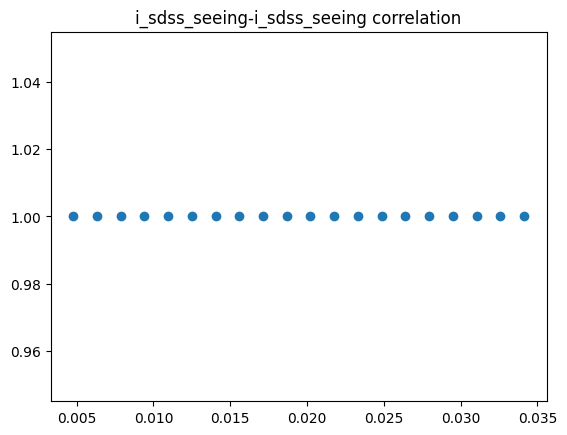

In [64]:
# creat a heat map of corr.mat.

print(corr_mat[:,1,1].shape)

#import matplotlib.cm as cm
#ax = fig.add_subplot(111)
for i in range(n):
    for j in range(n):
        plt.title('%s-%s correlation'%(map_names[i],map_names[j]))
        plt.scatter(theta_mid,corr_mat[:,i,j]) 
        plt.show()
#ax.set_xticklabels(alpha)  
#ax.set_yticklabels(alpha)

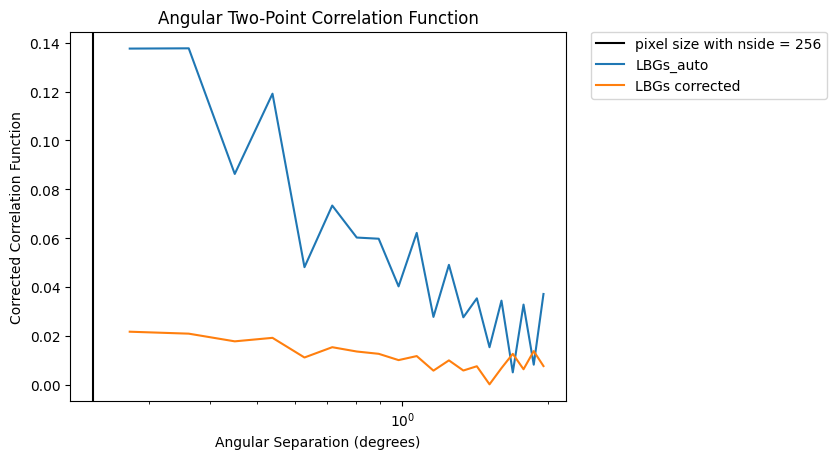

In [44]:
#wc = w_corrected()
plt.axvline(theta_pix, color='black', label='pixel size with nside = %d'%nside)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Angular Separation (degrees)')
plt.ylabel('Corrected Correlation Function')
theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
plt.plot(np.degrees(theta_mid), w['LBGs_vs_LBGs'], label = 'LBGs_auto')
plt.plot(np.degrees(theta_mid), w_c, label = 'LBGs corrected')
plt.title('Angular Two-Point Correlation Function')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()